In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"

Want to compare my best ML algorithm results to a Neural Network

In [3]:
offers_classed=pd.read_pickle("final_table_nf.pkl")

In [4]:
labels=offers_classed['successful_offer'].values
print(len(labels))

66501


In [5]:
features = offers_classed.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income', 'female', 'male', 'other','total_spend','transaction','viewed'])
print(len(features))



66501


In [6]:
def quantileScale (df,col):
    col=df.filter(col)
    col_scaled=quantile_transform(col, copy=False)
    col=pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df.update(col)
    return (df)



In [7]:
features.columns

Index(['reward', 'difficulty', 'duration', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational', 'age', 'became_member_on', 'income',
       'female', 'male', 'other', 'total_spend', 'transaction', 'viewed'],
      dtype='object')

Scale all features using the quantile transformation (including the new features added during the benchmark refinement phase)

In [8]:
features.dtypes

,0
reward,float64
difficulty,float64
duration,float64
mobile,float64
social,float64
web,float64
bogo,uint8
discount,uint8
informational,uint8
age,int64


In [9]:
features=features.astype(float)

features=quantileScale(features, ['reward', 'difficulty', 'duration', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational', 'age', 'became_member_on', 'income',
       'female', 'male', 'other', 'total_spend', 'transaction', 'viewed'])

features=features.values


In [10]:
features[0]

array([0.        , 0.        , 0.        , 1.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.13763764,
       0.43343343, 0.64064064, 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        ])

In [11]:
#Convert features and labels to tensors
features = torch.as_tensor(features, dtype=torch.float)
labels = torch.as_tensor(labels, dtype=torch.long)

In [12]:
features[0], labels[0]

(tensor([0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.1376, 0.4334, 0.6406, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000]),
 tensor(1))

In [13]:
## Split data into three random datasets
torch.manual_seed(42)
# Generate randomic indices
len_dataset = len(features)
random_idx = np.random.choice(len_dataset, len_dataset, replace=False)

# Use the proportions: train: 70%, valid: 15%, test: 15%
train_idx = random_idx[:int(len_dataset*0.70)]
valid_idx = random_idx[-int(len_dataset*0.15):]
test_idx = random_idx[int(len_dataset*0.70):-int(len_dataset*0.15)]

# Create datasets
train_dataset = TensorDataset(features[train_idx], labels[train_idx])
valid_dataset = TensorDataset(features[valid_idx], labels[valid_idx])
test_dataset = TensorDataset(features[test_idx], labels[test_idx])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Making sure the split has maintained balanced classes

In [14]:
#Counting the training labels
train_neg = (labels[train_idx] == 0).sum()
train_pos = (labels[train_idx] == 1).sum()
train_total=len(train_idx)
print('Training data has {} unsuccessful events and {} successful events \nThe ratio between classes is:\t {:0.2f} : {:0.2f}\n'.format(train_neg, train_pos, train_neg/train_total, train_pos/train_total))

#Counting the validating labels
valid_neg = (labels[valid_idx] == 0).sum()
valid_pos = (labels[valid_idx] == 1).sum()
valid_total =len(valid_idx)
print('Validation data has {} unsuccessful events and {} successful events \nThe ratio between classes is:\t {:0.2f} : {:0.2f}\n'.format(valid_neg, valid_pos, valid_neg/valid_total, valid_pos/valid_total))

#Counting the testing labels
test_neg = (labels[test_idx] == 0).sum()
test_pos = (labels[test_idx] == 1).sum()
test_total =len(test_idx)
print('Testing data has {} unsuccessful events and {} successful events \nThe ratio between classes is:\t {:0.2f} : {:0.2f}\n'.format(test_neg, test_pos, test_neg/test_total, test_pos/test_total))


Training data has 26696 unsuccessful events and 19854 successful events 
The ratio between classes is:	 0.57 : 0.43

Validation data has 5735 unsuccessful events and 4240 successful events 
The ratio between classes is:	 0.57 : 0.43

Testing data has 5632 unsuccessful events and 4344 successful events 
The ratio between classes is:	 0.56 : 0.44



In [15]:
class LinearNN(nn.Module):
    def __init__(self, input_size, hidden_layers=[128,128],
                 output_size=2, dropout=0.2):
        super(LinearNN, self).__init__()
        self.input_size = input_size

        nodes = []
        nodes.append(input_size)
        nodes.extend(hidden_layers)
        nodes.append(output_size)

        self.module_list = nn.ModuleList()
        for nodes_in, nodes_out in zip(nodes[:-1], nodes[1:]):
            layer = nn.Linear(nodes_in, nodes_out)
            self.module_list.append(layer)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        for layer in self.module_list[:-1]:
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)
        x = self.module_list[-1](x)

        return x

In [16]:
def validate(model, dataloader=valid_dataloader):
    model.eval()  # Set model to evaluation mode
    valid_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for features, labels in dataloader:
            features = features.to(device)
            labels = labels.to(device)

            # Forward pass
            prediction = model(features)

            # Adjust shapes and compute loss
            prediction = prediction.view(-1, 2)
            labels = labels.view(-1)
            valid_loss += criterion(prediction, labels)

            # Compute predictions and extend lists
            prediction = torch.softmax(prediction, dim=1)
            _, predicted_classes = prediction.topk(1, dim=1)
            predicted_classes = predicted_classes.squeeze().cpu().numpy()
            y_pred.extend(predicted_classes)

            y_true.extend(labels.cpu().numpy())

    # Normalize the loss
    valid_loss /= len(dataloader)
    valid_loss = valid_loss.item()

    # Compute confusion matrix and classification report
    con_mat = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, digits=4, target_names=['unsuccessful', 'successful'], output_dict=False)

    model.train()  # Set model back to training mode

    return valid_loss, con_mat, class_report

In [17]:
def train(model, model_name='classifier',
          dataloader=train_dataloader, epochs=200):
    train_loss = []
    valid_loss = []
    min_valid_loss = np.inf

    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for batch, (features, labels) in enumerate(dataloader):
            features=features.to(device)
            labels=labels.to(device)
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            prediction = prediction.view(-1,2)
            labels = labels.view(-1)
            loss = criterion(prediction, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the training loss
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)

        # LR scheduler step
        lr_scheduler.step(train_loss[-1])

        # Validate
        metrics = validate(model)
        valid_loss.append(metrics[0])
        print('Epoch {:4d}\ttrain loss: {:7.4f}\tvalidation loss: {:7.4f}' \
              .format(epoch, train_loss[-1], valid_loss[-1]))

        # Only save the model if valid_loss has decreased
        if valid_loss[-1] < min_valid_loss:
            min_valid_loss = valid_loss[-1]
            torch.save(model.state_dict(), model_name+'.pt')

    return train_loss, valid_loss

In [18]:
NNclassifier = LinearNN(input_size=18, output_size=2, hidden_layers=[256,256,256]).to(device)

criterion = nn.CrossEntropyLoss(torch.tensor([(float(train_neg) / float(train_pos)), 1]).to(device))

optimizer = torch.optim.Adam(NNclassifier.parameters(), lr=0.0001, weight_decay=0.0001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1, patience=15)

In [19]:
float(train_neg)/(float(train_pos))

1.3446156945703636

In [20]:
%%time
#100 takes 12min 8s
#200 takes 27min 9s

linear_loss = train(NNclassifier, model_name='NN_classifier', epochs=100)

Epoch    1	train loss:  0.5889	validation loss:  0.5668
Epoch    2	train loss:  0.5663	validation loss:  0.5577
Epoch    3	train loss:  0.5596	validation loss:  0.5551
Epoch    4	train loss:  0.5545	validation loss:  0.5537
Epoch    5	train loss:  0.5511	validation loss:  0.5525
Epoch    6	train loss:  0.5495	validation loss:  0.5490
Epoch    7	train loss:  0.5467	validation loss:  0.5483
Epoch    8	train loss:  0.5457	validation loss:  0.5484
Epoch    9	train loss:  0.5428	validation loss:  0.5468
Epoch   10	train loss:  0.5420	validation loss:  0.5466
Epoch   11	train loss:  0.5413	validation loss:  0.5482
Epoch   12	train loss:  0.5400	validation loss:  0.5475
Epoch   13	train loss:  0.5394	validation loss:  0.5449
Epoch   14	train loss:  0.5381	validation loss:  0.5447
Epoch   15	train loss:  0.5377	validation loss:  0.5444
Epoch   16	train loss:  0.5369	validation loss:  0.5443
Epoch   17	train loss:  0.5356	validation loss:  0.5431
Epoch   18	train loss:  0.5355	validation loss: 

In [21]:
#evaluation metrics
loss, con_mat, class_report=  validate(NNclassifier, test_dataloader)

In [22]:
print(class_report)

              precision    recall  f1-score   support

unsuccessful     0.7046    0.8473    0.7694      5632
  successful     0.7315    0.5394    0.6209      4344

    accuracy                         0.7132      9976
   macro avg     0.7180    0.6933    0.6951      9976
weighted avg     0.7163    0.7132    0.7047      9976



<Axes: >

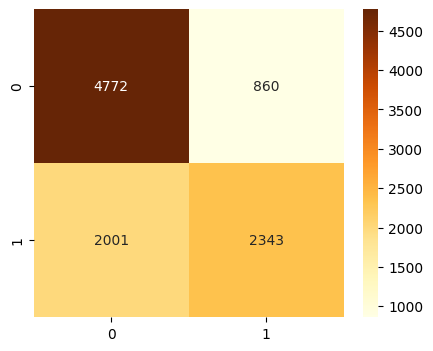

In [23]:
plt.figure(figsize = (5,4))
sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

<font size=4>Refinement and Optimising for Recall<font/>

weighting train_pos by 1.35

In [24]:
NNclassifier = LinearNN(input_size=18, output_size=2, hidden_layers=[256,256,256]).to(device)

criterion = nn.CrossEntropyLoss(torch.tensor([(float(train_neg) / float(1.35*train_pos)), 1]).to(device))

optimizer = torch.optim.Adam(NNclassifier.parameters(), lr=0.0001, weight_decay=0.0001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1, patience=15)

In [25]:
%%time
#200 takes 16min 35s

linear_loss = train(NNclassifier, model_name='NNclassifier', epochs=100)

Epoch    1	train loss:  0.6119	validation loss:  0.5903
Epoch    2	train loss:  0.5899	validation loss:  0.5853
Epoch    3	train loss:  0.5840	validation loss:  0.5789
Epoch    4	train loss:  0.5784	validation loss:  0.5768
Epoch    5	train loss:  0.5748	validation loss:  0.5789
Epoch    6	train loss:  0.5728	validation loss:  0.5745
Epoch    7	train loss:  0.5703	validation loss:  0.5714
Epoch    8	train loss:  0.5683	validation loss:  0.5717
Epoch    9	train loss:  0.5665	validation loss:  0.5707
Epoch   10	train loss:  0.5648	validation loss:  0.5761
Epoch   11	train loss:  0.5633	validation loss:  0.5700
Epoch   12	train loss:  0.5635	validation loss:  0.5692
Epoch   13	train loss:  0.5614	validation loss:  0.5722
Epoch   14	train loss:  0.5605	validation loss:  0.5681
Epoch   15	train loss:  0.5608	validation loss:  0.5696
Epoch   16	train loss:  0.5596	validation loss:  0.5671
Epoch   17	train loss:  0.5587	validation loss:  0.5678
Epoch   18	train loss:  0.5576	validation loss: 

In [26]:
#evaluation metrics
loss, con_mat, class_report=  validate(NNclassifier, test_dataloader)

In [27]:
print(class_report)

              precision    recall  f1-score   support

unsuccessful     0.7239    0.7930    0.7569      5632
  successful     0.6937    0.6080    0.6480      4344

    accuracy                         0.7124      9976
   macro avg     0.7088    0.7005    0.7025      9976
weighted avg     0.7108    0.7124    0.7095      9976



<Axes: >

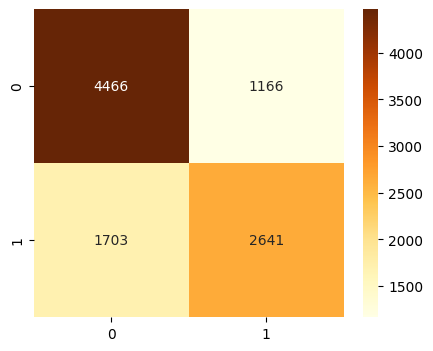

In [28]:
plt.figure(figsize = (5,4))
sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

In [29]:
# Benchmark
#Best parameters for recall found on training set are:
#{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
#
#precision    recall  f1-score   support

#unsuccessful     0.7303    0.7918    0.7598      5677
#  successful     0.6907    0.6139    0.6500      4299

#    accuracy                         0.7151      9976
#   macro avg     0.7105    0.7028    0.7049      9976
#weighted avg     0.7132    0.7151    0.7125      9976

##New Stuff

In [30]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [31]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [32]:
offers_classed=pd.read_pickle("final_table_nf.pkl")

In [33]:
def quantileScale (df,col):
    col=df.filter(col)
    col_scaled=quantile_transform(col, copy=False)
    col=pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df.update(col)
    return (df)


In [34]:
features = offers_classed.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income', 'female', 'male', 'other','total_spend','transaction','viewed'])
print(len(features))

66501


In [35]:
features=features.astype(float)

features=quantileScale(features, ['reward', 'difficulty', 'duration', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational', 'age', 'became_member_on', 'income',
       'female', 'male', 'other', 'total_spend', 'transaction', 'viewed'])

X=features.values


In [36]:
y=offers_classed['successful_offer'].values


In [37]:


# 80% Train, 20% Temp (to split further into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the 20% temp set into 10% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 53200
Validation set size: 6650
Test set size: 6651


In [38]:
# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Use long for classification
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [39]:
# Create TensorDataset for each split
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for each split
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [40]:
class LinearNNV2(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.linear_layer_stack=nn.Sequential(
        nn.Linear(in_features=18, out_features=512),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=512, out_features=512),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(in_features=512, out_features=1)
    )

    def forward(self, x):
        return self.linear_layer_stack(x)


In [41]:
model_2=LinearNNV2().to(device)
model_2

LinearNNV2(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=18, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [42]:
pd.DataFrame(y_test_tensor.cpu().numpy()).value_counts()/len(y_test_tensor)

,count
0,
0,0.568336
1,0.431664


In [43]:
# Calculate the weights
#weight_0 = 1.0
#weight_1 = 1.0 / (0.43 / 0.57)  # Adjust weight for the minority class

# Convert weights to a tensor
#pos_weight = torch.tensor([weight_1], dtype=torch.float32).to(device)

# Define the loss function with the pos_weight parameter
#loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

loss_fn = nn.BCEWithLogitsLoss()

#Uncomment this if you want to train your model to focus more on the positive class
# Calculate the weights
#weight_0 = 1.0
#weight_1 = 1.0 / (0.43 / 0.57)  # Adjust weight for the minority class




#Create an optimizer
optimizer=torch.optim.Adam(params=model_2.parameters(),
                          lr=0.001, weight_decay=0.0001)


lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

#pos_weight = torch.tensor([float(train_neg) / float(train_pos)])
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [44]:
def accuracy_fn(y_true, y_pred):
  correct=torch.eq(y_true, y_pred).sum().item()
  acc=correct/len(y_pred) * 100
  return acc

In [45]:
def train_step(data_loader: torch.utils.data.DataLoader,
               model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               lr_scheduler: torch.optim.lr_scheduler._LRScheduler,  # Add lr_scheduler
               accuracy_fn,
               device:torch.device = device):
  """Performs a single training step over a single batch
  """
  ###Training
  train_loss=0
  train_acc=0

  #Put model into training mode
  model.train()

  #Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):

      X,y = X.to(device), y.to(device)

      #1. Forward pass
      #y_pred=model_0(X)
      y_logits=model(X)

      #2. Calculate the loss
      loss=loss_fn(y_logits.squeeze(), y.type(torch.float32))
      train_loss+=loss

      #ipdb.set_trace()
      y_prob=torch.sigmoid(y_logits)
      y_pred=torch.round(y_prob).squeeze()
      accuracy=accuracy_fn(y_true=y, y_pred=y_pred)
      train_acc+=accuracy

      #3 Optimize zero grad
      optimizer.zero_grad()

      #4. Loss backward
      loss.backward()

      #5. Optimizer step
      optimizer.step()

      ##print out
      #if batch % 400 == 0:
      #    print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples")

  lr_scheduler.step(train_loss)

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"\nTrain loss: {train_loss:.5f} | Train acc: {train_acc:.3f}%")


In [46]:
def val_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device:torch.device = device):
  """Performs a single training step over a single batch
  """
  val_loss, val_acc=0, 0
  model.eval()
  with torch.inference_mode():
    for X_val, y_val in data_loader:
      X_val,y_val = X_val.to(device), y_val.to(device)
      #forward pass
      val_logits=model(X_val)

      #calculate loss
      val_loss=loss_fn(val_logits.squeeze(), y_val.type(torch.float32))
      val_loss+=val_loss

      #calculate accuracy
      val_prob=torch.sigmoid(val_logits)
      val_pred=torch.round(val_prob).squeeze()
      val_acc+=accuracy_fn(y_true=y_val, y_pred=val_pred)

    val_loss /= len(data_loader)
    val_acc /= len(data_loader)

  print(f"\nValidation loss: {val_loss:.5f} | Validation acc: {val_acc:.3f}%")

In [47]:
from timeit import default_timer as timer


def print_train_time(start: float,
                    end: float,
                    device: torch.device=None):
  """
  Prints the difference between start and end time
  """
  total_time=end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [48]:
#import progress bar
from tqdm.auto import tqdm

#Set the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start_on_cpu=timer()

#Set the number of epochs
epochs=100

#Put data on target device
#train_dataloader, test_dataloader=train_dataloader.to(device), test_dataloader.to(device)

#Put model on target device
model_2.to(device)

for epoch in tqdm(range(epochs)):

    print(f"Epoch: {epoch}\n---------")

    train_step(model=model_2,
               data_loader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               lr_scheduler=lr_scheduler,
               accuracy_fn=accuracy_fn,
               device=device)

    val_step(model=model_2,
              data_loader=val_loader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

    if epoch % 5 == 0:
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.8f}")




#Calculate training time
train_time_end_on_cpu=timer()
total_train_time_model_1=print_train_time(start=train_time_start_on_cpu,
                                          end=train_time_end_on_cpu,
                                          device=str(next(model_2.parameters()).device))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
---------

Train loss: 0.59569 | Train acc: 68.155%

Validation loss: 0.01155 | Validation acc: 70.164%
Learning Rate: 0.00100000
Epoch: 1
---------

Train loss: 0.57835 | Train acc: 69.494%

Validation loss: 0.01214 | Validation acc: 69.590%
Epoch: 2
---------

Train loss: 0.57289 | Train acc: 69.999%

Validation loss: 0.01202 | Validation acc: 70.585%
Epoch: 3
---------

Train loss: 0.57009 | Train acc: 70.367%

Validation loss: 0.01136 | Validation acc: 70.884%
Epoch: 4
---------

Train loss: 0.56777 | Train acc: 70.435%

Validation loss: 0.01208 | Validation acc: 70.330%
Epoch: 5
---------

Train loss: 0.56638 | Train acc: 70.502%

Validation loss: 0.01135 | Validation acc: 70.962%
Learning Rate: 0.00100000
Epoch: 6
---------

Train loss: 0.56516 | Train acc: 70.532%

Validation loss: 0.01152 | Validation acc: 70.696%
Epoch: 7
---------

Train loss: 0.56401 | Train acc: 70.827%

Validation loss: 0.01145 | Validation acc: 70.451%
Epoch: 8
---------

Train loss: 0.56378 | Tr

In [49]:
import torch
from sklearn.metrics import confusion_matrix, classification_report

def test(X_test: torch.Tensor,
         y_test: torch.Tensor,
         model: torch.nn.Module,
         loss_fn: torch.nn.Module,
         accuracy_fn,
         device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Tests the model on the test data tensors.

    Args:
        X_test: Tensor containing test features.
        y_test: Tensor containing test labels.
        model: The PyTorch model to test.
        loss_fn: Loss function.
        accuracy_fn: Accuracy function (or any other metric function).
        device: The device on which to perform testing (CPU or GPU).

    Returns:
        Tuple containing average test loss, accuracy, confusion matrix, and classification report.
    """
    # Put the model in evaluation mode
    model.eval()

    # Initialize loss and accuracy accumulators
    test_loss = 0.0
    test_acc = 0.0

    # No gradient calculation needed for testing
    with torch.no_grad():
        # Move test data to the appropriate device
        X_test, y_test = X_test.to(device), y_test.to(device)

        # Forward pass: get model predictions
        y_logits = model(X_test)
        y_prob = torch.sigmoid(y_logits)
        y_pred = torch.round(y_prob).squeeze()

        # Calculate the loss
        loss = loss_fn(y_logits.squeeze(), y_test.type(torch.float32))
        test_loss = loss.item()

        # Calculate accuracy
        accuracy = accuracy_fn(y_true=y_test, y_pred=y_pred)
        test_acc = accuracy

    # Compute confusion matrix
    con_matrix = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().numpy())

    # Generate classification report
    class_report = classification_report(y_test.cpu().numpy(), y_pred.cpu().numpy(),
                                          target_names=['Unsuccessful', 'Successful'],
                                          output_dict=False, digits=4)

    print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.3f}%")
    print(f"Classification Report:\n{class_report}")

    return test_loss, test_acc, con_matrix, class_report


In [50]:
test_loss, test_acc, con_matrix, class_report= test(X_test_tensor, y_test_tensor , model_2, loss_fn, accuracy_fn)

Test Loss: 0.55290 | Test Accuracy: 70.982%
Classification Report:
              precision    recall  f1-score   support

Unsuccessful     0.7238    0.7915    0.7561      3780
  Successful     0.6869    0.6022    0.6418      2871

    accuracy                         0.7098      6651
   macro avg     0.7053    0.6969    0.6990      6651
weighted avg     0.7079    0.7098    0.7068      6651



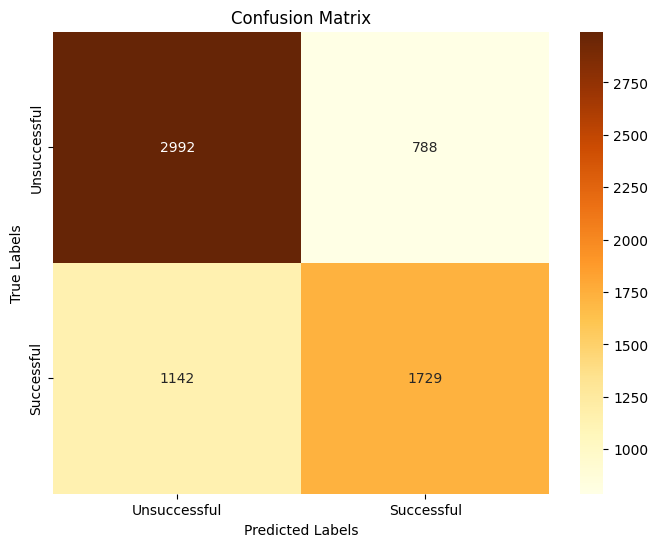

In [51]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Sample class names; replace these with your actual class names
class_names = ['Unsuccessful', 'Successful']   # Adjust according to your problem



# Create a figure and axis object
plt.figure(figsize=(8, 6))

# Create the heatmap with annotations
ax = sn.heatmap(con_matrix, annot=True, cmap='YlOrBr', fmt='g',
                xticklabels=class_names, yticklabels=class_names)

# Add labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()

#Rerunning the model with a focus on the positive class


I presume it will increase the recall for a positive class a lot.

In [52]:
model_3=LinearNNV2().to(device)
model_3

LinearNNV2(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=18, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [53]:
#you can also really increase the positive class:
weight_1=3

# Convert weights to a tensor
pos_weight = torch.tensor([weight_1], dtype=torch.float32).to(device)

# Define the loss function with the pos_weight parameter
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

#Create an optimizer
optimizer=torch.optim.Adam(params=model_3.parameters(),
                          lr=0.001, weight_decay=0.0001)


lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

#pos_weight = torch.tensor([float(train_neg) / float(train_pos)])
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [54]:
#import progress bar
from tqdm.auto import tqdm

#Set the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start_on_cpu=timer()

#Set the number of epochs
epochs=100

#Put data on target device
#train_dataloader, test_dataloader=train_dataloader.to(device), test_dataloader.to(device)

#Put model on target device
model_3.to(device)

for epoch in tqdm(range(epochs)):

    print(f"Epoch: {epoch}\n---------")

    train_step(model=model_3,
               data_loader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               lr_scheduler=lr_scheduler,
               accuracy_fn=accuracy_fn,
               device=device)

    val_step(model=model_3,
              data_loader=val_loader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

    if epoch % 5 == 0:
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.8f}")




#Calculate training time
train_time_end_on_cpu=timer()
total_train_time_model_3=print_train_time(start=train_time_start_on_cpu,
                                          end=train_time_end_on_cpu,
                                          device=str(next(model_3.parameters()).device))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
---------

Train loss: 1.00294 | Train acc: 57.803%

Validation loss: 0.02025 | Validation acc: 59.465%
Learning Rate: 0.00100000
Epoch: 1
---------

Train loss: 0.97332 | Train acc: 60.015%

Validation loss: 0.02141 | Validation acc: 56.906%
Epoch: 2
---------

Train loss: 0.96585 | Train acc: 60.767%

Validation loss: 0.02125 | Validation acc: 59.419%
Epoch: 3
---------

Train loss: 0.95954 | Train acc: 60.592%

Validation loss: 0.02038 | Validation acc: 61.587%
Epoch: 4
---------

Train loss: 0.95614 | Train acc: 60.718%

Validation loss: 0.02197 | Validation acc: 59.480%
Epoch: 5
---------

Train loss: 0.95397 | Train acc: 60.919%

Validation loss: 0.02051 | Validation acc: 60.926%
Learning Rate: 0.00100000
Epoch: 6
---------

Train loss: 0.95053 | Train acc: 61.311%

Validation loss: 0.02035 | Validation acc: 59.093%
Epoch: 7
---------

Train loss: 0.94904 | Train acc: 61.377%

Validation loss: 0.02007 | Validation acc: 57.677%
Epoch: 8
---------

Train loss: 0.94775 | Tr

In [55]:
test_loss, test_acc, con_matrix, class_report= test(X_test_tensor, y_test_tensor , model_3, loss_fn, accuracy_fn)

Test Loss: 0.92761 | Test Accuracy: 62.607%
Classification Report:
              precision    recall  f1-score   support

Unsuccessful     0.8701    0.4021    0.5500      3780
  Successful     0.5392    0.9209    0.6801      2871

    accuracy                         0.6261      6651
   macro avg     0.7046    0.6615    0.6151      6651
weighted avg     0.7272    0.6261    0.6062      6651



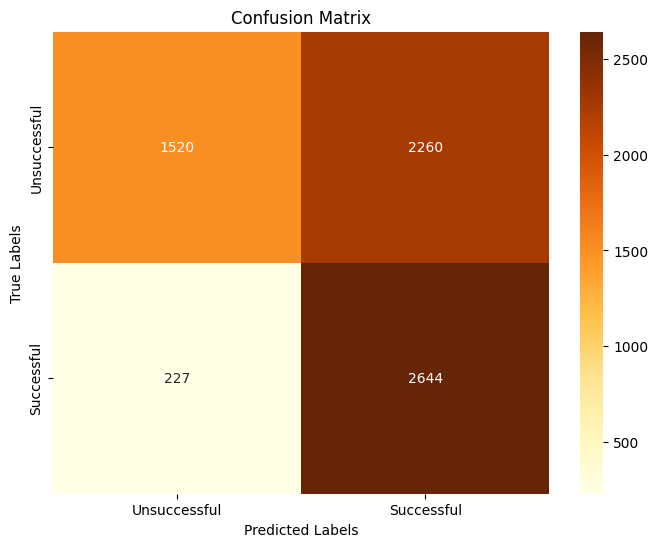

In [56]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Sample class names; replace these with your actual class names
class_names = ['Unsuccessful', 'Successful']   # Adjust according to your problem



# Create a figure and axis object
plt.figure(figsize=(8, 6))

# Create the heatmap with annotations
ax = sn.heatmap(con_matrix, annot=True, cmap='YlOrBr', fmt='g',
                xticklabels=class_names, yticklabels=class_names)

# Add labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()